In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/projection_model.pth
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/model.safetensors
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-model_fin/generation_config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/merges.txt
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/vocab.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/tokenizer_config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_2/gpt-2-tokenizer_fin/special_tokens_map.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_0/projection_model.pth
/kaggle/input/cxr-dataset/checkpoints_findings/epoch_0/gpt-2-model_fin/config.json
/kaggle/input/cxr-dataset/checkpoints_findings/epoc

In [2]:
import numpy as np
import cv2
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import itertools
import torch.optim as optim
import torch.nn.functional as F
import math

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2Model

# Vérification du dispositif disponible pour PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
df_projections = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
df_reports = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')


In [4]:
df_reports

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [5]:
images_captions_df = pd.DataFrame({'image': [],
                                    'caption': [],'number_of_words':[]})
for i in range(len(df_projections)):
    uid = df_projections.iloc[i]['uid']
    image = df_projections.iloc[i]['filename']
    index = df_reports.loc[df_reports['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df_reports.iloc[index]['findings']
       
        number_of_words = len(str(caption).split())

        if type(caption) == float:
                continue
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'image': image, 'caption': caption ,'number_of_words':number_of_words}])], ignore_index=True)

images_captions_df["number_of_words"] =  images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

images_captions_df

,image,caption,number_of_words
0,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...,34
1,1_IM-0001-3001.dcm.png,The cardiac silhouette and mediastinum size ar...,34
2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...,14
3,2_IM-0652-2001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...,14
4,4_IM-2050-1001.dcm.png,There are diffuse bilateral interstitial and a...,64
...,...,...,...
6464,3995_IM-2046-2001.dcm.png,The cardiomediastinal silhouette and pulmonary...,74
6465,3996_IM-2047-1001.dcm.png,The lungs are clear. Heart size is normal. No ...,17
6466,3996_IM-2047-3001.dcm.png,The lungs are clear. Heart size is normal. No ...,17
6467,3997_IM-2048-1001.dcm.png,"Heart size within normal limits. Small, nodula...",31


In [6]:
image_folder = '/kaggle/input/cxr-dataset/images'
image_filenames = images_captions_df.image.values


train_captions,test_captions =train_test_split(images_captions_df, test_size = 0.2)
print(train_captions.shape)
print (test_captions.shape)

(5175, 3)
(1294, 3)


In [7]:
train_captions

,image,caption,number_of_words
5458,3382_IM-1629-0001-0001.dcm.png,Prominent interstitial markings. There are sma...,35
3894,2406_IM-0954-1001.dcm.png,Both lungs remain clear and expanded. Heart an...,19
5002,3112_IM-1461-1001.dcm.png,The heart is normal in size. The mediastinum i...,14
2568,1561_IM-0367-2001.dcm.png,"Lungs are clear without focal consolidation, e...",15
3816,2358_IM-0922-0001-0002.dcm.png,The heart is normal in size. The pulmonary vas...,28
...,...,...,...
3469,2138_IM-0760-1002.dcm.png,Normal heart size. Stable tortuous thoracic ao...,39
782,474_IM-2101-1001.dcm.png,The lungs are clear. There is no pleural effus...,22
6040,3731_IM-1865-2001.dcm.png,Lungs are clear. Heart and mediastinum appear ...,13
4950,3084_IM-1443-1001.dcm.png,Heart size is normal. No pleural effusions. No...,23


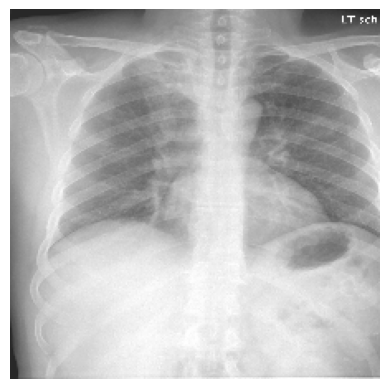

(224, 224, 3)


In [8]:
batch_size = 16
image_size = 224

def preprocess_image(image_path, image_size):
    """
    Loads and preprocesses an image.
    
    Args:
        image_path (str): Path to the image to load.
        target_size (int): The new size of the images (assumes square images).
    
    Returns:
        numpy.ndarray: The preprocessed image.
    """
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, (image_size, image_size))
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image_np):
    """
    Displays an image.
    
    Args:
        image_np (numpy.ndarray): The image to display.
    """
    plt.imshow(image_np)
    plt.axis('off')  # Hide axis labels
    plt.show()
image = preprocess_image("/kaggle/input/cxr-dataset/images/1000_IM-0003-1001.dcm.png",image_size)
display_image (image)
print(image.shape)

In [9]:
num_processors = os.cpu_count()

class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=image_size):
        """
        Initializes the dataset.
        
        Args:
            image_filenames (list): List of image file paths.
            captions (list): List of corresponding captions.
            image_size (int): Target size for the images.
        """
        self.image_filenames = image_filenames
        self.captions = captions
        self.image_size = image_size
        self.transform = transforms.Compose([transforms.ToTensor()])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_path = f"/kaggle/input/cxr-dataset/images/{self.image_filenames[idx]}"
        image = preprocess_image(image_path, self.image_size)
        image = self.transform(image)
        caption = self.captions[idx]
        return image, caption

In [10]:
# Create dataset instances
train_dataset = ImageTextDataset(train_captions.image.values, train_captions.caption.values) #,image_size)
test_dataset = ImageTextDataset(test_captions.image.values, test_captions.caption.values ) # ,image_size)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_dataset. __getitem__(0)[0].shape)

torch.Size([3, 224, 224])


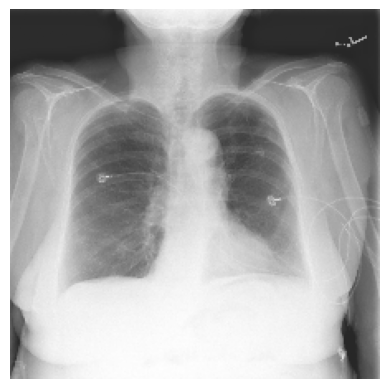

Caption: Heart size is normal. Tortuous aorta. Irregular 1.2 cm opacity in the left upper lung is identified both on PA and lateral views and XXXX represents chronic scarring. She has a partial resection of the posterior fourth rib. No pneumothorax. No pleural effusion. No focal infiltrate. Anterior wedging of multiple vertebral bodies including T6, T8, T11 and T12.




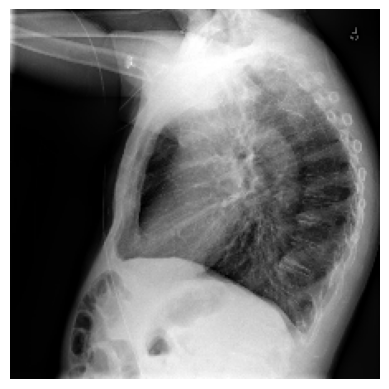

Caption: There is a subtle left medial base opacity. Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. No pneumothorax or large pleural effusion. Osseous structures and soft tissues are normal.




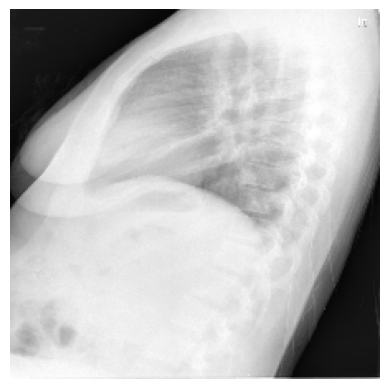

Caption: No pneumothorax or large pleural effusion. Mildly prominent perihilar opacities, XXXX due to bronchovascular crowding. Heart size within normal limits. Cardiomediastinal silhouette is XXXX. The bony structures appear intact.




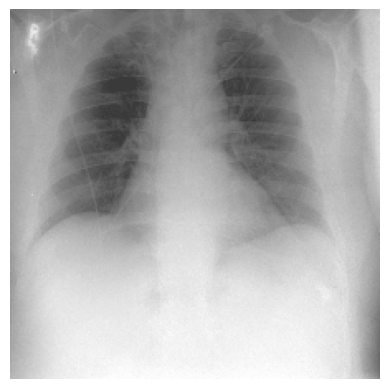

Caption: There is a right chest XXXX with catheter tip at the cavoatrial junction. Heart size is at the upper limits of normal. Lungs are grossly clear. No pleural effusion or pneumothorax. There are diffuse degenerative changes of the spine.




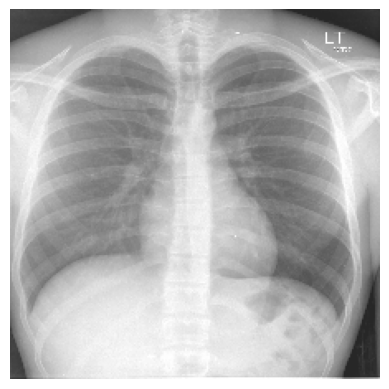

Caption: The trachea is midline. The cardiomediastinal silhouette appears normal. There are no acute infiltrates, effusions. There is no evidence of pneumothorax. Visualized bony structures are intact with no acute abnormalities.




In [11]:
images_batch, captions_batch = next(iter(train_dataloader))

for i in range(5):  # Display the first 5 images and captions
    image_to_display = images_batch[i].permute(1, 2, 0).numpy()
    caption_to_display = captions_batch[i]
    display_image(image_to_display)
    print(f"Caption: {caption_to_display}\n\n")

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


In [13]:
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

'''# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)'''

'''from transformers import AutoTokenizer, AutoModel
model_name= "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)'''

"""from transformers import GPT2Tokenizer, GPT2Model
modele_name='gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(modele_name)
model = GPT2Model.from_pretrained(modele_name)
"""

from transformers import AutoTokenizer, AutoModel
model_name='emilyalsentzer/Bio_ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

# List of input texts
texts = [ "Salus ", "comment vas tu .", "cher.", "ami" ]
# Generate embeddings
embeddings = generate_text_embeddings(texts)
print("Shape of embeddings:", embeddings.shape)  # Should print (num_texts, embedding_size)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Shape of embeddings: torch.Size([4, 768])


In [14]:
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

count_trainable_parameters(model)

108310272

In [15]:
dropout = 0.1
class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings

class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings

batch_idx:  0  Image Shape:  torch.Size([16, 3, 224, 224]) Text Count:  16


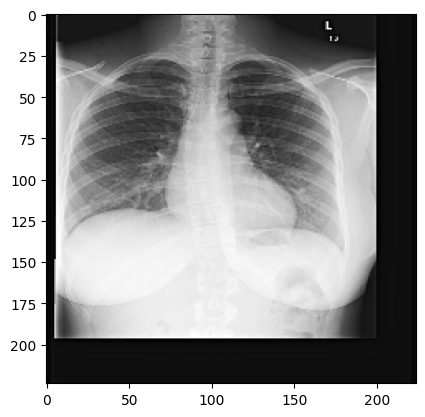

CHEST. The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a calcified granuloma in the left lung base. SOFT TISSUE NECK. There is reversal of the normal cervical lordosis which may indicate muscle spasm versus a positional phenomenon. There is no prevertebral soft tissue XXXX. The epiglottis is within normal limits. There is a 3 mm x 1 mm density identified on the lateral exam only, possibly within one of the piriform sinuses.


In [16]:
# Set the environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "true" 

# Checking Data Setup
for batch_idx, (images, texts) in enumerate(train_dataloader):
    print( "batch_idx: ", batch_idx, " Image Shape: ", images.shape, "Text Count: ", len(texts) )
    plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
    plt.show()
    print(texts[0])
    break

In [17]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 2

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

In [18]:
### - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space
#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -

# - - - - - - - - - - - - - - -- - Image Encodeur Modele - - - - - - - - - - -- - - - - - - - - -
'''# - - - - - - - - - ViT  Model from scratch - - - - - - - - -
image_size = 224
patch_size = 16
d_model = 512*4
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024  # d_i

ViT_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers).to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(ViT_model))'''

# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
print(" Number of Trainable Parameters in", " ResNet50 Model :  ",   count_trainable_parameters(resnet_model))

'''# - - - - - - - - - ViT pre-trained Model - - - - - - - - -

from transformers import ViTModel, ViTFeatureExtractor , ViTImageProcessor

# Charger l'extracteur de caractéristiques et le modèle ViT pré-entraîné
# Définir la taille des embeddings d'image en fonction de la sortie du modèle ViT
image_embedding_size = 768  # Cette valeur doit correspondre à la taille de sortie du modèle ViT que vous utilisez
# Initialiser le processeur d'image ViT
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(ViT_model))'''


# - - - - - - - - - - - - - - -- - Text Encodeur Modele - - - - - - - - - - -- - - - - - - - - -

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 200
text_embedding_size = 768  # d_i

'''# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) 
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " distilbert-base-uncased model :  ",   count_trainable_parameters(text_model))
'''

# - - - - - - - - -  Bio_ClinicalBERT  - - - - - - - - -

from transformers import AutoTokenizer, AutoModel
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
print(" Number of Trainable Parameters in", " Bio_ClinicalBERT model :  ",   count_trainable_parameters(text_model))


# - - - - - - - - -  gpt2  - - - - - - - - -

'''modele_name='gpt2'
text_tokenizer = GPT2Tokenizer.from_pretrained(modele_name)
# Définir le token de padding comme le token EOS
text_tokenizer.pad_token = text_tokenizer.eos_token
text_model = GPT2Model.from_pretrained(modele_name).to(device)
print(" Number of Trainable Parameters in", " gpt2 model :  ",   count_trainable_parameters(text_model))'''


# - - - - - - - - -  BiomedCLIP-PubMedBERT_256-vit_base_patch16_224  - - - - - - - - -

'''from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

print(" Number of Trainable Parameters in", " BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 model :  ",   count_trainable_parameters(text_model))'''


# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(ViT_model.parameters())+ list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
optimizer = optim.AdamW([
    {"params": resnet_model.parameters(), "lr": 1e-4},
    {"params": text_model.parameters(), "lr": 1e-5},
    {"params": image_projector.parameters(), "lr": 1e-3},
    {"params": text_projector.parameters(), "lr": 1e-3},
    ], weight_decay=1e-3)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )

# import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # step_size=step_size
# warmup_epochs = 25  # Number of epochs for warm-up

# - - - - - - - - -  Training loop  - - - - - - - - -
num_epochs = 1
for epoch in range(num_epochs):
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    #ViT_model.train()
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
              # - - - -  Traitement de l' image avec Resnet5  - - - -  
        images = images.to(device)
        image_embeddings = resnet_model(images)
        # Ajout de l'étape d'aplatissement pour ResNet
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings
        image_projection = image_projector(image_embeddings)
                
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()
        
#     if epoch < warmup_epochs:
#         scheduler.step(epoch)
#     else:
#         scheduler.step()
        
        # - - - - Loss print - - - -
        total_loss += loss.item()
        
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
            
    # - - - - Loss each epoch
    lr_scheduler.step(total_loss)
    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds")
    
'''            # - - - -  Traitement de l'image avec ViT pré-entrainer  - - - - 
        pixel_values = images.to(device)
        # Obtenir les embeddings d'images du modèle ViT
        outputs = ViT_model(pixel_values=pixel_values)
        image_embeddings = outputs.last_hidden_state[:, 0, :]  # Utiliser les embeddings du premier token (CLS)
        image_projection = image_projector(image_embeddings)
        
        # - - - -  Traitement de l'image avec ViT frm scratch  - - - - 
        images = images.to(device)
        image_embeddings = ViT_model(images)
        image_projection = image_projector(image_embeddings)'''

'''        # - - - -  Traitement de l' image avec Resnet5  - - - -  
        images = images.to(device)
        image_embeddings = resnet_model(images)
        # Ajout de l'étape d'aplatissement pour ResNet
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings
        image_projection = image_projector(image_embeddings)'''

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


 Number of Trainable Parameters in  ResNet50 Model :   23508032
 Number of Trainable Parameters in  Bio_ClinicalBERT model :   108310272
 Number of Trainable Parameters in  Image Projection :   1312768
 Number of Trainable Parameters in  Text Projection :   657408

 - - - - - - - - - - 
 
  Training......  
 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/1], Batch [0/324], Loss: 0.4873
Epoch [1/1], Batch [200/324], Loss: 0.2455
Epoch [1/1], Average Loss: 3.5114   Time Taken:  6077.834629774094  seconds


"        # - - - -  Traitement de l' image avec Resnet5  - - - -  \n        images = images.to(device)\n        image_embeddings = resnet_model(images)\n        # Ajout de l'étape d'aplatissement pour ResNet\n        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings\n        image_projection = image_projector(image_embeddings)"

In [19]:
print(f"Forme des embeddings d'image avant projection: {image_embeddings.shape}")
image_projection = image_projector(image_embeddings)

Forme des embeddings d'image avant projection: torch.Size([7, 2048])


In [20]:
accuracy_counter = 0

#ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
       # - - - -  Traitement de l' image avec Resnet5  - - - -  
        images = images.to(device)
        image_embeddings = resnet_model(images)
        # Ajout de l'étape d'aplatissement pour ResNet
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings
        image_projection = image_projector(image_embeddings)
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1

total_samples = len(test_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

'''        # - - - -  Image avec Resnet5  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        # Ajout de l'étape d'aplatissement pour ResNet
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings
        image_projection = image_projector(image_embeddings)'''

'''        # - - - -  Image avec ViT  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = ViT_model(batch_images)
        image_projection = image_projector(image_embeddings)'''

'''        # - - - -  Traitement de l'image avec ViT pré-entrainer  - - - - 
        pixel_values = images.to(device)
        # Obtenir les embeddings d'images du modèle ViT
        outputs = ViT_model(pixel_values=pixel_values)
        image_embeddings = outputs.last_hidden_state[:, 0, :]  # Utiliser les embeddings du premier token (CLS)
        image_projection = image_projector(image_embeddings)'''

100%|██████████| 81/81 [08:02<00:00,  5.96s/it]

Accuracy (Pencentage of Correct Matching): 6.2597


"        # - - - -  Traitement de l'image avec ViT pré-entrainer  - - - - \n        pixel_values = images.to(device)\n        # Obtenir les embeddings d'images du modèle ViT\n        outputs = ViT_model(pixel_values=pixel_values)\n        image_embeddings = outputs.last_hidden_state[:, 0, :]  # Utiliser les embeddings du premier token (CLS)\n        image_projection = image_projector(image_embeddings)"

In [21]:
try:
    checkpoint = {
        #'ViT_model_dict': ViT_model.state_dict(),
        'resnet_model_dict': resnet_model.state_dict(),
        'text_model_dict': text_model.state_dict(),
        'image_projector_dict': image_projector.state_dict(),
        'text_projector_dict': text_projector.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, "/kaggle/working/CLIP_model_from_Scratch_ResNet_DistilBERT")
    
except:
    print("Error in some saving")

  0%|          | 0/81 [00:00<?, ?it/s]

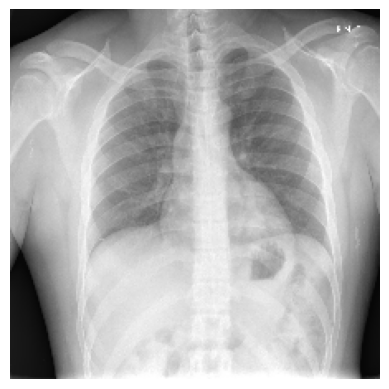

Original Caption: In the interval, a 2 cm diameter nodule has developed in the posterior segment of the left lower lobe. It is not calcified. No other infiltrates or masses in the lungs. Heart and pulmonary XXXX are normal. XXXX are normal.
Predicted Caption: The heart size is normal. No pneumothorax. No large pleural effusions. No focal airspace opacities.



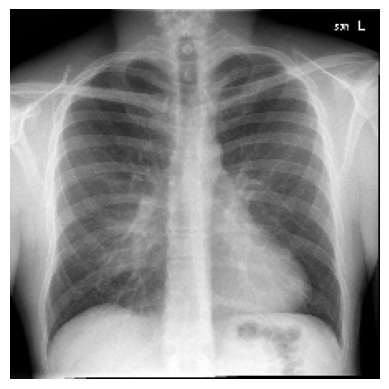

Original Caption: XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. Aortic XXXX appear unremarkable. Lungs demonstrate no acute findings. There is no effusion or pneumothorax. Bilateral prominent lung vascularity medially, unchanged.
Predicted Caption: The heart size is normal. No pneumothorax. No large pleural effusions. No focal airspace opacities.



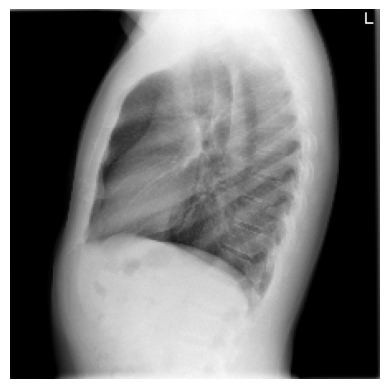

Original Caption: The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. No discrete nodules or adenopathy identified.
Predicted Caption: The heart size is normal. No pneumothorax. No large pleural effusions. No focal airspace opacities.



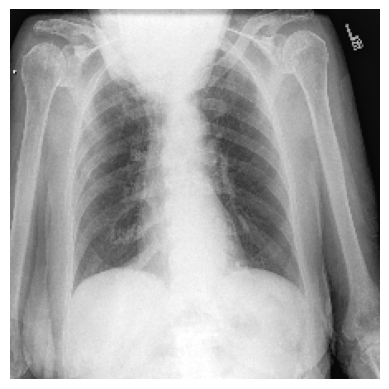

Original Caption: The XXXX examination consists of frontal and lateral radiographs of the chest. Upper thorax is poorly visualized due to patient's overlying head and chin. The cardiomediastinal contours are within normal limits. Background of mild coarse interstitial opacities seen throughout the lungs XXXX related to background of emphysema. Calcified granuloma is seen in the left medial lung base. There is no consolidation, pleural effusion or pneumothorax. Deformity of the right 6th rib laterally has appearance of acute or subacute fracture. Degenerative changes of the thoracic spine are again seen.
Predicted Caption: The heart size is normal. No pneumothorax. No large pleural effusions. No focal airspace opacities.



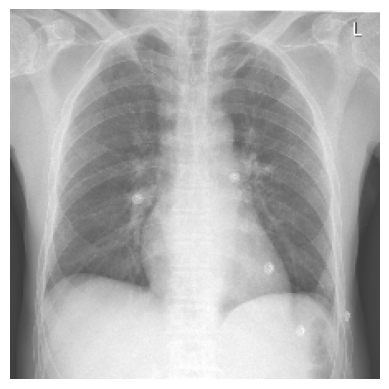

  1%|          | 1/81 [00:02<02:47,  2.09s/it]

Original Caption: The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiomediastinal contours are within normal limits. There is right greater than left biapical bullous emphysema. No focal consolidation, pleural effusion, or pneumothorax identified. There are XXXX degenerative changes of the thoracic spine.
Predicted Caption: The heart size is normal. No pneumothorax. No large pleural effusions. No focal airspace opacities.



  1%|          | 1/81 [00:03<04:01,  3.02s/it]


"        # - - - -  Obtention des embeddings et projection avec Vit pre-entrainer   - - - - \n        pixel_values = images.to(device)\n        # Obtenir les embeddings d'images du modèle ViT\n        outputs = ViT_model(pixel_values=pixel_values)\n        image_embeddings = outputs.last_hidden_state[:, 0, :]  # Utiliser les embeddings du premier token (CLS)\n        image_projection = image_projector(image_embeddings)"

In [22]:
import matplotlib.pyplot as plt

# Fonction pour afficher une image
def display_image(image_tensor):
    plt.figure()
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
# Initialisation des listes pour stocker les légendes originales et prédites
original_captions = []
predicted_captions = []

# Préparation pour l'évaluation
#ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

with torch.no_grad():
    examples_shown = 0  # Compteur pour s'assurer de montrer seulement 5 exemples
    for batch_images, batch_captions in tqdm(test_dataloader):
        if examples_shown >= 5:
            break  # Arrêter après avoir affiché 5 exemples

        batch_images = batch_images.to(device)
        batch_size = batch_images.size(0)
        

        # - - - - Obtention des embeddings et projections model resnet50  - - - - 
        images = images.to(device)
        image_embeddings = resnet_model(images)
        # Ajout de l'étape d'aplatissement pour ResNet
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings
        image_projection = image_projector(image_embeddings)

        
        # Boucle sur les images du lot
        for index in range(batch_size):
            # Calcul des similarités
            similarity_scores = torch.matmul(image_projection[index:index+1], text_projection.T).squeeze(0)
            max_index = torch.argmax(similarity_scores).item()
            
            # Récupération des légendes
            original_caption = batch_captions[index]
            predicted_caption = batch_captions[max_index]
            
            # Affichage de l'image
            display_image(batch_images[index].cpu())
            # Impression des légendes en dessous
            print(f"Original Caption: {original_caption}")
            print(f"Predicted Caption: {predicted_caption}\n")
            
            examples_shown += 1
            if examples_shown >= 5:
                break
        
'''        # Obtention des embeddings et projections model resnet 
        image_embeddings = resnet_model(batch_images)
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)  # Aplatir les embeddings pour ResNet
        image_projection = image_projector(image_embeddings)'''

'''        # Obtention des embeddings et projections avec ViT from scratch 
        image_embeddings = ViT_model(batch_images)
        image_projection = image_projector(image_embeddings)'''

'''        # - - - -  Obtention des embeddings et projection avec Vit pre-entrainer   - - - - 
        pixel_values = images.to(device)
        # Obtenir les embeddings d'images du modèle ViT
        outputs = ViT_model(pixel_values=pixel_values)
        image_embeddings = outputs.last_hidden_state[:, 0, :]  # Utiliser les embeddings du premier token (CLS)
        image_projection = image_projector(image_embeddings)'''